<a href="https://colab.research.google.com/github/Jammal7/DataScience_Project/blob/main/Probabilistic_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [2]:
import io
import requests

url ="https://raw.githubusercontent.com/Jammal7/DataScience_Project/main/CGA%20Portfolio%20Project/Probabilistic%20Sales%20Forecasting/Data/supermarket_sales_data"
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


## Basic Data Checkup

In [3]:
# Checking for nulls
df.isna().sum()

Invoice ID                 0
Branch                     0
City                       0
Customer type              0
Gender                     0
Product line               0
Unit price                 0
Quantity                   0
Tax 5%                     0
Total                      0
Date                       0
Time                       0
Payment                    0
cogs                       0
gross margin percentage    0
gross income               0
Rating                     0
dtype: int64

In [4]:
df.shape

(1000, 17)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Total                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

In [6]:
# Unique Values
obj_col = df.columns
for col in obj_col:
    print("{}: {}".format(col,len(df[col].unique())))

Invoice ID: 1000
Branch: 3
City: 3
Customer type: 2
Gender: 2
Product line: 6
Unit price: 943
Quantity: 10
Tax 5%: 990
Total: 990
Date: 89
Time: 506
Payment: 3
cogs: 990
gross margin percentage: 1
gross income: 990
Rating: 61


The data appears to be fairly clean, based on my observations. Something to look into:

* Data have 1000 samples without missing any information
* We may need to convert the date and time later on
* The `Invoice ID` need to be excluded as not to cause overfitting
* The `gross margin percentage` has only 1 value, which does not given us any meaning

So we drop `Invoice ID` and `gross margin percentage` attributes first

In [7]:
df = df.drop(columns=['Invoice ID', 'gross margin percentage'])
df.head()

,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross income,Rating
0,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,26.1415,9.1
1,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,3.8200,9.6
2,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,16.2155,7.4
3,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,23.2880,8.4
4,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,30.2085,5.3


## Exploratory Data Analysis(EDA)

In [8]:
#removing blank spaces from column names
df.columns = df.columns.str.replace(' ','_')

In [9]:
df.head()

,Branch,City,Customer_type,Gender,Product_line,Unit_price,Quantity,Tax_5%,Total,Date,Time,Payment,cogs,gross_income,Rating
0,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,26.1415,9.1
1,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,3.8200,9.6
2,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,16.2155,7.4
3,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,23.2880,8.4
4,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,30.2085,5.3


In [10]:
df.shape

(1000, 15)

### Branch 

In [11]:
df['Branch'].value_counts()

A    340
B    332
C    328
Name: Branch, dtype: int64

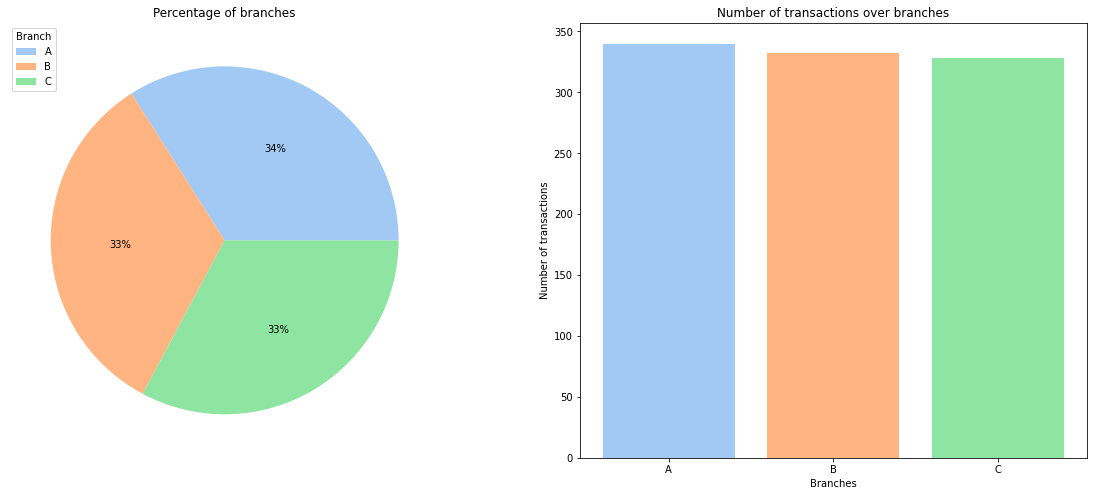

In [12]:
branch_count = df['Branch'].value_counts()

colors = sns.color_palette('pastel')
fig, ax = plt.subplots(1,2,figsize=(20,8))

ax[0].pie(branch_count.values,labels=branch_count.index,autopct='%0.f%%',labeldistance=None,colors=colors)
ax[0].legend(title='Branch')
ax[0].set_title("Percentage of branches")

ax[1].bar(x=branch_count.index,height=branch_count,color=colors)
ax[1].set_ylabel("Number of transactions")
ax[1].set_xlabel("Branches")
ax[1].set_title("Number of transactions over branches")

plt.show()

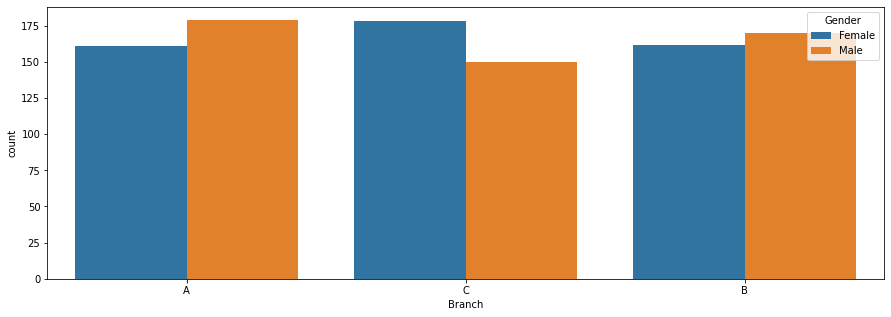

In [13]:
plt.figure(figsize=(15,5))
sns.countplot(data=df, x="Branch", hue="Gender");

Branch A has the highest sales compared to other branches followed by branch B then branch C. When you compared the customer Gender in we see that most males are in branch A with the highest followed by branch B ,branch C has females as the most customers.

In [14]:
# Let's find which branch was most successful in terms of Total (revenue?) and Ratings
df.groupby('Branch')['Total'].sum().sort_values(ascending=False)

Branch
C    110568.7065
A    106200.3705
B    106197.6720
Name: Total, dtype: float64

In [15]:
df.groupby('Branch')['Rating'].mean().sort_values(ascending=False)

Branch
C    7.072866
A    7.027059
B    6.818072
Name: Rating, dtype: float64

In [16]:
# Which Branch gets the higher ratings from the Members
member_rating = df[df.Customer_type == 'Member']
member_rating.groupby('Branch')['Rating'].mean().sort_values(ascending=False)

Branch
C    7.048521
A    6.998802
B    6.770303
Name: Rating, dtype: float64

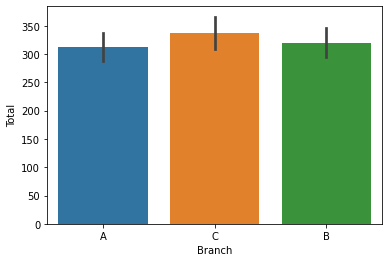

In [17]:
# average spend on each branch
sns.barplot(x = 'Branch', y = 'Total', data = df);

From this graph, we can see that `Branch C` generate more average spend than `Branch A` and `Branch B`

### City

In [18]:
df['City'].value_counts()

Yangon       340
Mandalay     332
Naypyitaw    328
Name: City, dtype: int64

In [19]:
# Calculating the supermarket gross income based on the city it's in
avgyearlysales = df.groupby('City')['gross_income'].count().to_dict()
df_yearsales = pd.DataFrame(list(avgyearlysales.items()), 
                            columns = ['City','Count'])

fig = px.bar(df_yearsales, 
             x ='City', 
             y ='Count', 
             title =' Sales per City')
fig.show()

The supermarket in Yangon city had the highest gross income followed by the one in Mandalay city and Naypytaw city respectively.

In [20]:
df[['City', 'Payment']].value_counts(ascending=True)

City       Payment    
Naypyitaw  Credit card     98
Yangon     Credit card    104
Naypyitaw  Ewallet        106
Mandalay   Credit card    109
           Cash           110
Yangon     Cash           110
Mandalay   Ewallet        113
Naypyitaw  Cash           124
Yangon     Ewallet        126
dtype: int64

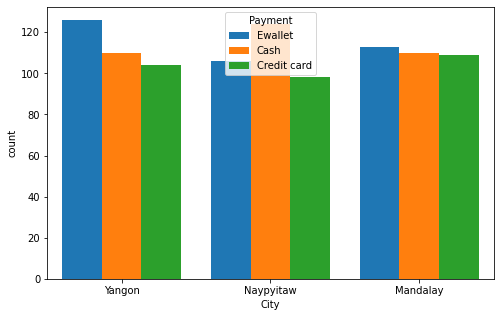

In [21]:
plt.figure(figsize = (8,5))
sns.countplot(data= df, x="City", hue="Payment", saturation=True);

When it comes to prefered method of payment across the 3 supermarket branches ,the branch in the largest city being Yangon as well as the second largest Mandalay city, we noticed that Ewallet is the most prefered payment time while cash is the most prefered payment time in the the less populated city of Napyitaw.

Credit card use is mostly used in Mandalay compared to the other braches but comes in third after Ewallet and Cash respectively.

### Customer Type

In [22]:
df['Customer_type'].value_counts()

Member    501
Normal    499
Name: Customer_type, dtype: int64

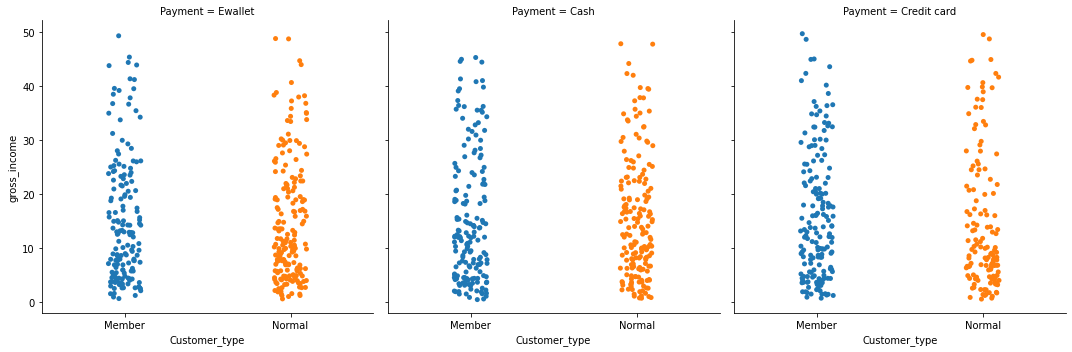

In [23]:
# Distribution of payment preference on Customer type
sns.catplot(x='Customer_type', y='gross_income', col='Payment', data = df)
plt.show()

In [24]:
#Comparing the supermarket customer type based on their gender 
df.groupby('Gender')['Customer_type'].value_counts()

Gender  Customer_type
Female  Member           261
        Normal           240
Male    Normal           259
        Member           240
Name: Customer_type, dtype: int64

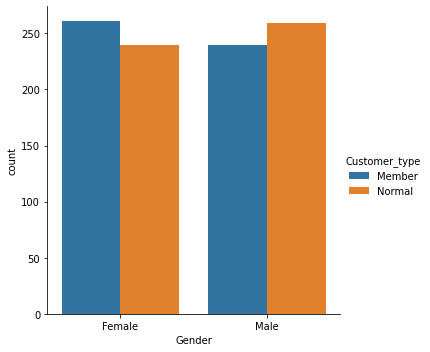

In [25]:
sns.catplot(data=df, x='Gender', kind='count', hue='Customer_type');

Most of the female customers are members at 261 compared to male customers at 240,while most of the males are of normal customer type 259 with female normal customers at 240.

In [26]:
df.groupby('Branch')['Customer_type'].value_counts()

Branch  Customer_type
A       Normal           173
        Member           167
B       Normal           167
        Member           165
C       Member           169
        Normal           159
Name: Customer_type, dtype: int64

When comparing the customer type with their branch we find out that supermarkets in branch A and B have the highest customer number who are normal while branch C has the highest in member customer type.

From our catplot above we found out that a majority of male customers were of normal customer type while the female were of member this plays out here where in branches A and B have the most male customers which relates to the overal customer type count.

### Gender

In [27]:
df['Gender'].value_counts()

Female    501
Male      499
Name: Gender, dtype: int64

Evenly distributed

In [28]:
df.groupby('Branch')['Gender'].value_counts()

Branch  Gender
A       Male      179
        Female    161
B       Male      170
        Female    162
C       Female    178
        Male      150
Name: Gender, dtype: int64

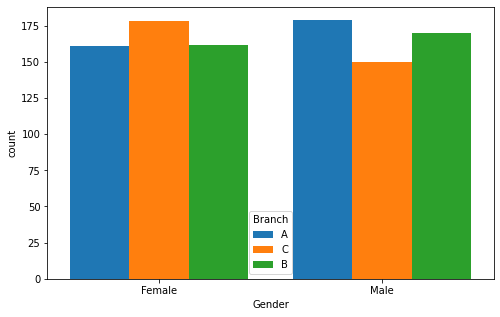

In [29]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="Gender", hue="Branch", saturation=True);

The number of female customers are mostly found in branch C while for the male customers a majority of them are found in branch A followed by brach B then branch C.

In [30]:
df.groupby('Gender')['Product_line'].value_counts()

Gender  Product_line          
Female  Fashion accessories       96
        Food and beverages        90
        Sports and travel         88
        Electronic accessories    84
        Home and lifestyle        79
        Health and beauty         64
Male    Health and beauty         88
        Electronic accessories    86
        Food and beverages        84
        Fashion accessories       82
        Home and lifestyle        81
        Sports and travel         78
Name: Product_line, dtype: int64

We find out that female customers have the most purchases in product lines of (Fashion accessories,Food and beverage,sports and travel). While the male customers have most purchases in Health and beauty, Electronic accessories with slight purchase difference in Home and lifestyle,electronic accessories.

### Product line

In [31]:
df['Product_line'].value_counts()

Fashion accessories       178
Food and beverages        174
Electronic accessories    170
Sports and travel         166
Home and lifestyle        160
Health and beauty         152
Name: Product_line, dtype: int64

In [32]:
product_avgyearlysales = df.groupby('Product_line')['gross_income'].count().to_dict()
df_yearlysales = pd.DataFrame(list(product_avgyearlysales.items()), 
                              columns = ['Product_line', 'Count'])

fig = px.bar(df_yearlysales,
             x = 'Product_line',
             y = 'Count',
             title = 'Sales per Product')
fig.show()


When it comes to sales based on Product Line Categories across all branches, Fashion accessories were the most sold at 17.8%(178) followed by Food and beverages at 17.4%(174) then Electronic accessories at 17%(170). Sports and travel items came in at fourth position with 16.6%(166) follwed by Health and lifestyle products at 16%(160) and the product that had it's sales lowest among the other categories was product line under Health and beauty at 15.2% (152).

Worth noting is how the distribution of these products fell between 17% as the most sold and 15% as the least sold.

In [33]:
df.groupby('Product_line')['City'].value_counts()

Product_line            City     
Electronic accessories  Yangon       60
                        Mandalay     55
                        Naypyitaw    55
Fashion accessories     Naypyitaw    65
                        Mandalay     62
                        Yangon       51
Food and beverages      Naypyitaw    66
                        Yangon       58
                        Mandalay     50
Health and beauty       Mandalay     53
                        Naypyitaw    52
                        Yangon       47
Home and lifestyle      Yangon       65
                        Mandalay     50
                        Naypyitaw    45
Sports and travel       Mandalay     62
                        Yangon       59
                        Naypyitaw    45
Name: City, dtype: int64

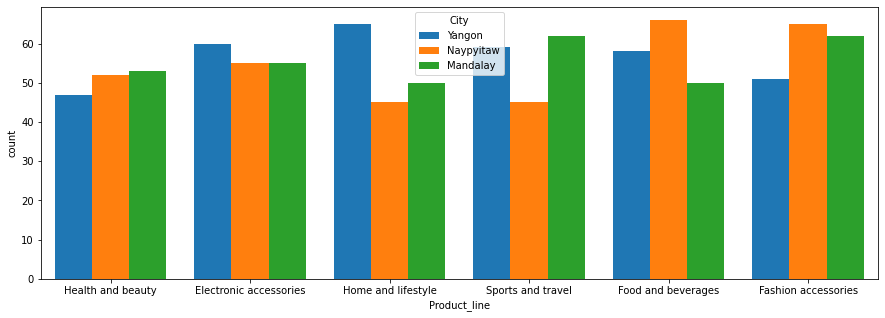

In [34]:
plt.figure(figsize=(15,5))
sns.countplot(data=df, x="Product_line", hue="City", saturation=True);

When it comes to Food and beverages, Fashion accessories (Product lines) the supermarket in Napyitaw has the most sales with Home and lifestyle tieing in Yangon with Fashion accessories sales in Napyitaw.

The branch in Mandalay has the most sales when it comes to sports and travel with fashion accessories sales coming second after Napyitaw branch.

This plot helps in finding out how the specific product line sells per branch an example is how sports and travel ,home and lifestyle sales are below 50 in Napyitaw compared to other braches while in Yangon branch health and beauty products sell below 50 compared to other branches.

### Date and Time

In [35]:
df['Date'] = pd.to_datetime(df['Date'])

df['Day'] = (df['Date']).dt.day
df['Month'] = (df['Date']).dt.month
df['Year'] = (df['Date']).dt.year

df = df.drop(columns=['Date'])

df.head()

,Branch,City,Customer_type,Gender,Product_line,Unit_price,Quantity,Tax_5%,Total,Time,Payment,cogs,gross_income,Rating,Day,Month,Year
0,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,13:08,Ewallet,522.83,26.1415,9.1,5,1,2019
1,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,10:29,Cash,76.40,3.8200,9.6,8,3,2019
2,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,13:23,Credit card,324.31,16.2155,7.4,3,3,2019
3,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,20:33,Ewallet,465.76,23.2880,8.4,27,1,2019
4,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,10:37,Ewallet,604.17,30.2085,5.3,8,2,2019


In [36]:
df['Year'] = df['Year'].replace([2019], 2022)
df.head()

,Branch,City,Customer_type,Gender,Product_line,Unit_price,Quantity,Tax_5%,Total,Time,Payment,cogs,gross_income,Rating,Day,Month,Year
0,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,13:08,Ewallet,522.83,26.1415,9.1,5,1,2022
1,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,10:29,Cash,76.40,3.8200,9.6,8,3,2022
2,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,13:23,Credit card,324.31,16.2155,7.4,3,3,2022
3,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,20:33,Ewallet,465.76,23.2880,8.4,27,1,2022
4,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,10:37,Ewallet,604.17,30.2085,5.3,8,2,2022


### Payment

In [37]:
df['Payment'].value_counts()

Ewallet        345
Cash           344
Credit card    311
Name: Payment, dtype: int64

In [38]:
df[['Gender', 'Payment']].value_counts(ascending=True).to_dict()

{('Female', 'Cash'): 178,
 ('Female', 'Credit card'): 163,
 ('Female', 'Ewallet'): 160,
 ('Male', 'Cash'): 166,
 ('Male', 'Credit card'): 148,
 ('Male', 'Ewallet'): 185}

In [39]:
#Payment preference types
gender_payment = df[['Payment','Gender']].value_counts().to_dict()
df_genderpayment = pd.DataFrame(list(gender_payment.items()),columns=['Payment','Gender'])
gender_paymentfig = px.pie(df_genderpayment,values='Gender',names='Payment',title='Customer Payment type by Gender',labels='Payment')
gender_paymentfig.update_traces(textposition='inside',textinfo='percent+label')
gender_paymentfig.show()

When we compare the payment type usage across the genders we find out that Ewallet use among male customers at 18.5% was the prefered payment type compared to it's female use at 16%.

### Checking for Outliers

In [40]:
df.describe()

,Unit_price,Quantity,Tax_5%,Total,cogs,gross_income,Rating,Day,Month,Year
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.0
mean,55.672130,5.510000,15.379369,322.966749,307.58738,15.379369,6.97270,15.256000,1.993000,2022.0
std,26.494628,2.923431,11.708825,245.885335,234.17651,11.708825,1.71858,8.693563,0.835254,0.0
min,10.080000,1.000000,0.508500,10.678500,10.17000,0.508500,4.00000,1.000000,1.000000,2022.0
25%,32.875000,3.000000,5.924875,124.422375,118.49750,5.924875,5.50000,8.000000,1.000000,2022.0
50%,55.230000,5.000000,12.088000,253.848000,241.76000,12.088000,7.00000,15.000000,2.000000,2022.0
75%,77.935000,8.000000,22.445250,471.350250,448.90500,22.445250,8.50000,23.000000,3.000000,2022.0
max,99.960000,10.000000,49.650000,1042.650000,993.00000,49.650000,10.00000,31.000000,3.000000,2022.0


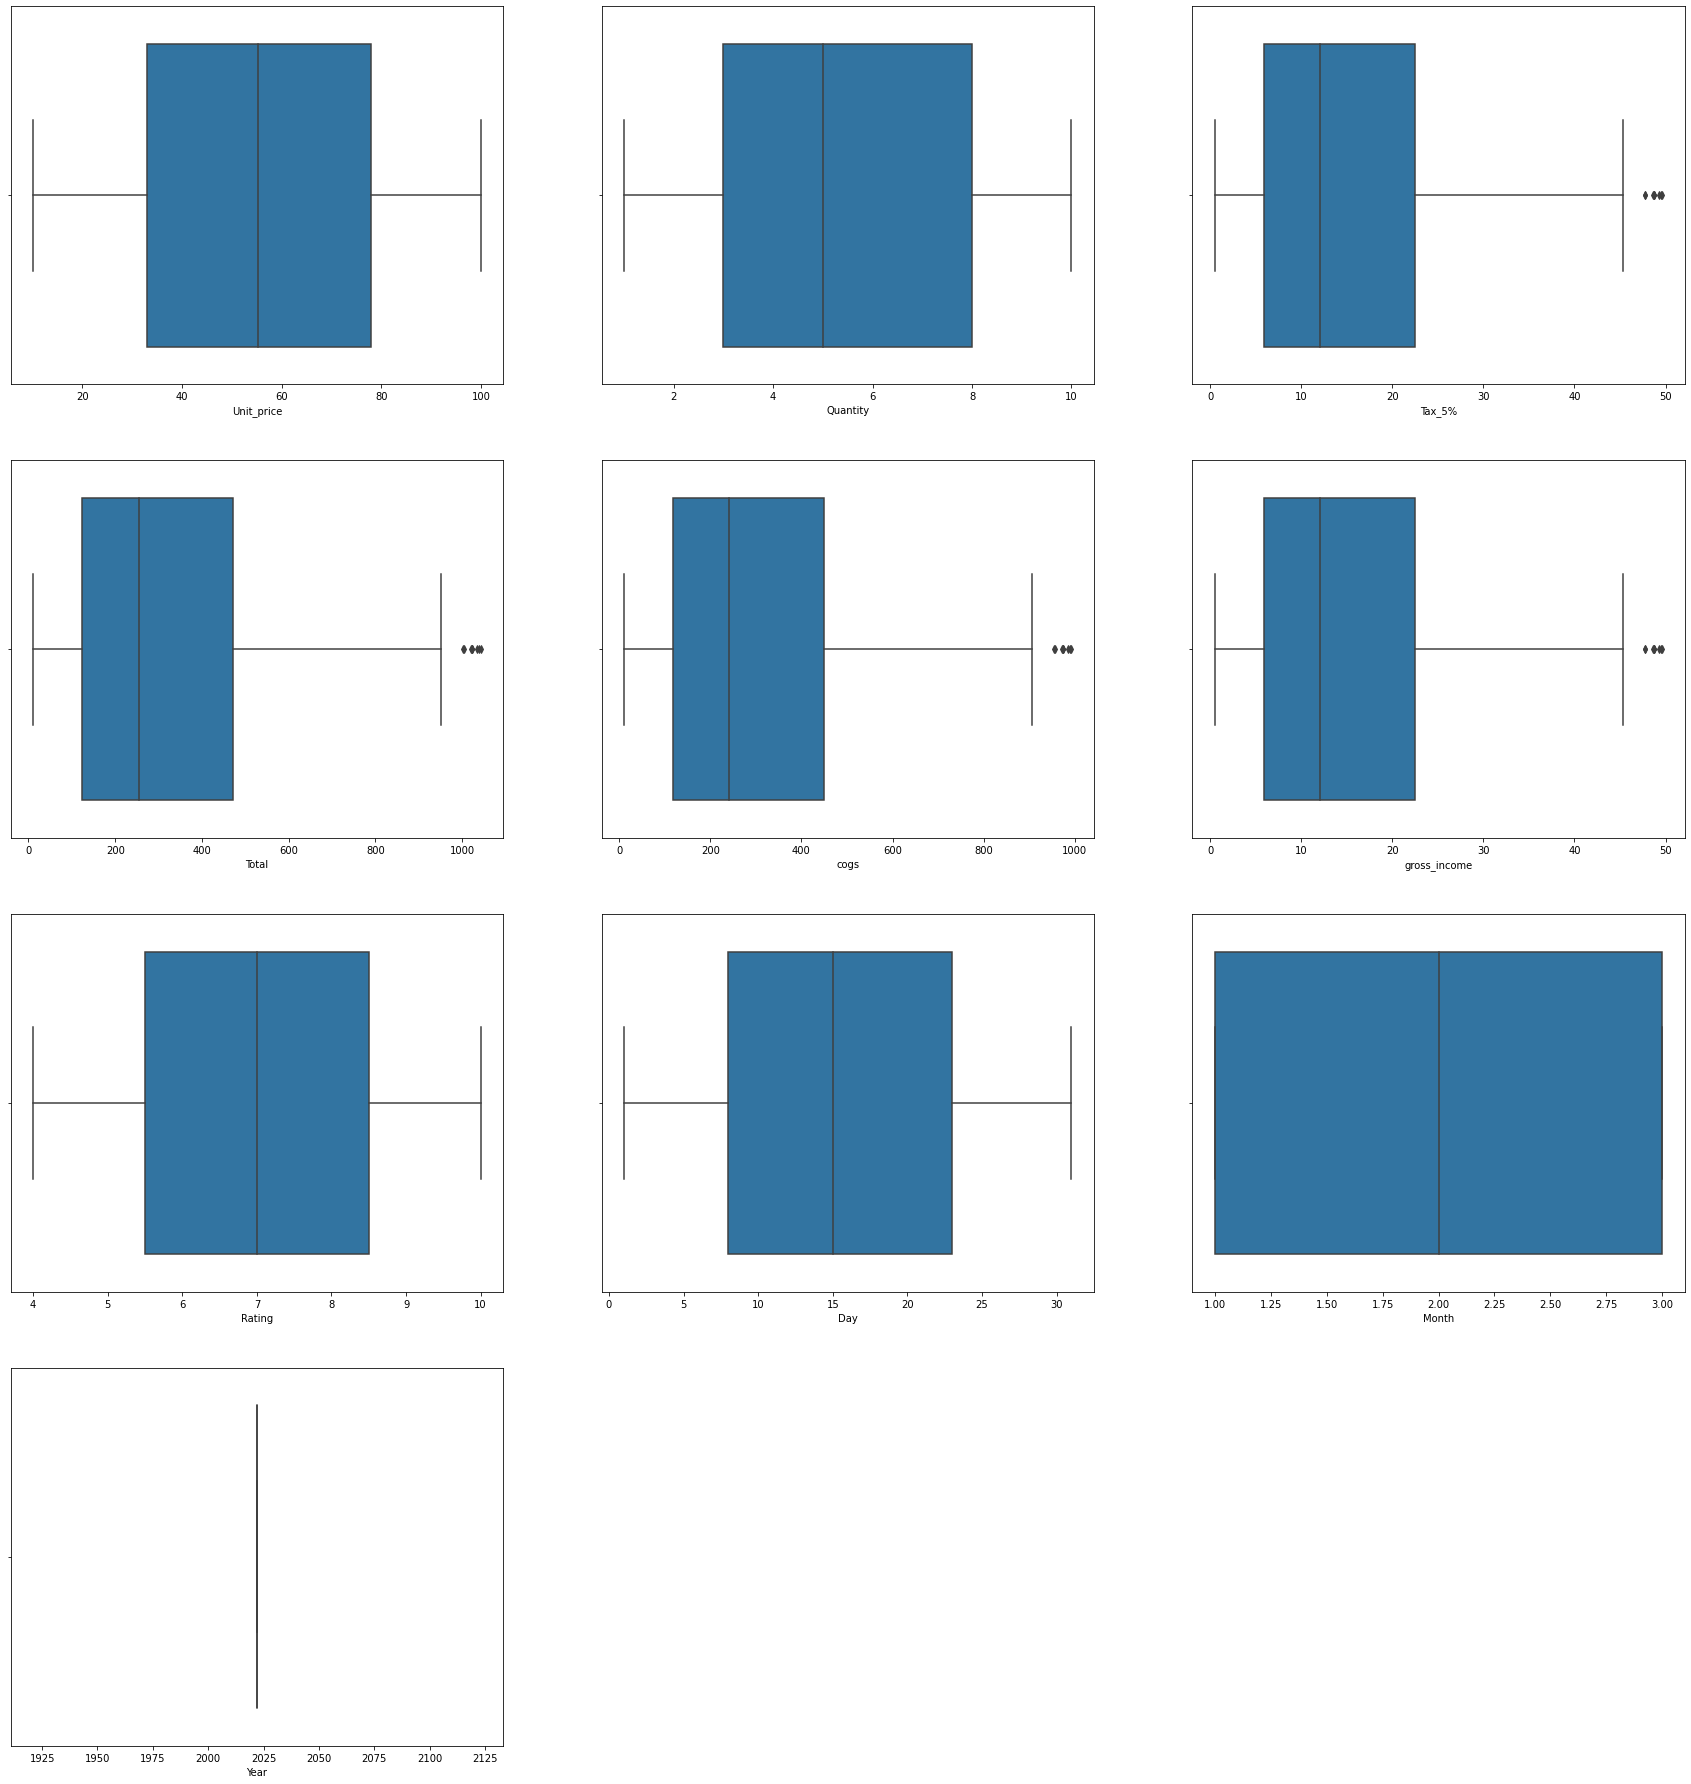

In [41]:
def check_outliers(df):
  num_col = df.select_dtypes(['float64', 'int64']).columns
  nCols = len(num_col)//3+1

  fig,ax = plt.subplots(nCols, 3, figsize = (30, 8*nCols))
  for i, col in enumerate(num_col):
        sns.boxplot(data=df, x=col, ax=ax[i//3][i%3])

  for i in range(len(num_col), 3*nCols):
        fig.delaxes(ax[i//3][i%3])

  plt.show()
    
check_outliers(df)

From the graphs above, we can see that `Tax 5%`, `cogs`, `Total` and `gross income` have outliers. So now I will remove outlier. Regarding to an attribute, if a value of it is out size 1.5 times IQR from mean, it will be treated as outliers

In [42]:
# def remove_outlier(df, col_name):
#     q = df[col_name].quantile([0.25, 0.5, 0.75])
#     IQR = q[0.75] - q[0.25]
#     lower = q[0.5] - 1.5*IQR
#     upper = q[0.5] + 1.5*IQR
#     return df[(df[col_name] >= lower) & (df[col_name] <= upper)]

# df = remove_outlier(df, 'Tax_5%')
# df = remove_outlier(df, 'cogs')
# df = remove_outlier(df, 'Total')
# df = remove_outlier(df, 'gross_income')

# check_outliers(df)

In [43]:
df.shape

(1000, 17)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Branch         1000 non-null   object 
 1   City           1000 non-null   object 
 2   Customer_type  1000 non-null   object 
 3   Gender         1000 non-null   object 
 4   Product_line   1000 non-null   object 
 5   Unit_price     1000 non-null   float64
 6   Quantity       1000 non-null   int64  
 7   Tax_5%         1000 non-null   float64
 8   Total          1000 non-null   float64
 9   Time           1000 non-null   object 
 10  Payment        1000 non-null   object 
 11  cogs           1000 non-null   float64
 12  gross_income   1000 non-null   float64
 13  Rating         1000 non-null   float64
 14  Day            1000 non-null   int64  
 15  Month          1000 non-null   int64  
 16  Year           1000 non-null   int64  
dtypes: float64(6), int64(4), object(7)
memory usage: 132.

### Correlation

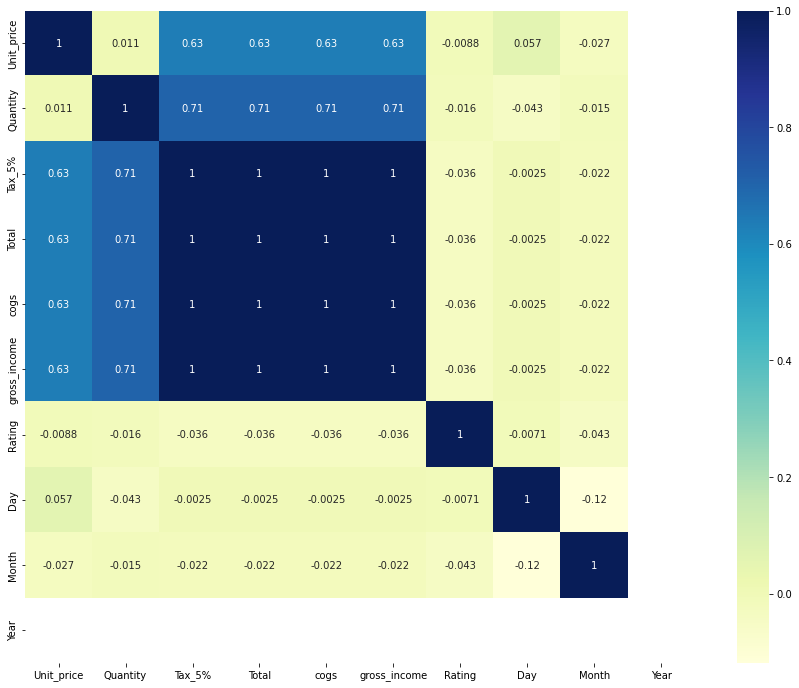

In [45]:
corr = df.corr(method = 'pearson')
plt.figure(figsize = (15,12))
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.show()

From the heatmap above, we can see that the `Total`, `cogs`, `Tax 5%`, `gross income` are perfectly correlated. This is very considerable, so let drop 3 of 4 attributes above (I choose cogs, gross income and Tax 5%).

In [46]:
df = df.drop(columns=['cogs','gross_income','Tax_5%'])
df.shape

(1000, 14)

In [47]:
df.head()

,Branch,City,Customer_type,Gender,Product_line,Unit_price,Quantity,Total,Time,Payment,Rating,Day,Month,Year
0,A,Yangon,Member,Female,Health and beauty,74.69,7,548.9715,13:08,Ewallet,9.1,5,1,2022
1,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,80.2200,10:29,Cash,9.6,8,3,2022
2,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,340.5255,13:23,Credit card,7.4,3,3,2022
3,A,Yangon,Member,Male,Health and beauty,58.22,8,489.0480,20:33,Ewallet,8.4,27,1,2022
4,A,Yangon,Normal,Male,Sports and travel,86.31,7,634.3785,10:37,Ewallet,5.3,8,2,2022


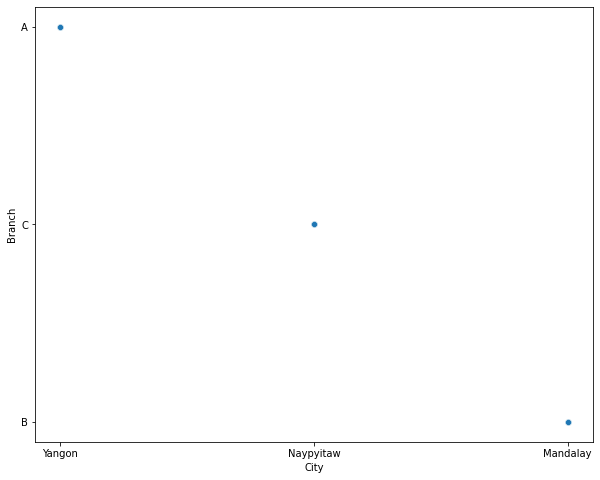

In [48]:
# Relationship of cities and branches
plt.figure(figsize=(10,8))
sns.scatterplot(data=df, x='City', y='Branch')
plt.show()

There is a relationship between `City` and `Branch`. Each branch is located at a specific city. So, we can also remove 1 of the two (I remove City in this case).

In [49]:
df = df.drop(columns="City")
df.head()

,Branch,Customer_type,Gender,Product_line,Unit_price,Quantity,Total,Time,Payment,Rating,Day,Month,Year
0,A,Member,Female,Health and beauty,74.69,7,548.9715,13:08,Ewallet,9.1,5,1,2022
1,C,Normal,Female,Electronic accessories,15.28,5,80.2200,10:29,Cash,9.6,8,3,2022
2,A,Normal,Male,Home and lifestyle,46.33,7,340.5255,13:23,Credit card,7.4,3,3,2022
3,A,Member,Male,Health and beauty,58.22,8,489.0480,20:33,Ewallet,8.4,27,1,2022
4,A,Normal,Male,Sports and travel,86.31,7,634.3785,10:37,Ewallet,5.3,8,2,2022


## Summary

1. From the dataset of a total of 1000 customers we see that there is an equal percentage distribution between it's male and female customers at 50% each. The dataset has an even distribution.
2. The most preferred payment type is Ewallet at 34.5% followed by Cash at 34.4% and Credit card at 31.1%. These differences are closely to each other ranging between 30% and 34%.
3. Ewallet use among male customers at 18.5% was the preferred payment type compared to it's female use at 16%.
4. When it comes to sales based on Product Line Categories across all branches, Fashion accessories were the most sold at 17.8% followed by Food and beverages at 17.4% then Electronic accessories at 17%.Sports and travel items came in at fourth position with 16.6% followed by Health and lifestyle products at 16% and the product that had it's sales lowest among the other categories was product line under Health and beauty at 15.2%.
5. The supermarket in Yangon city had the highest gross income followed by the one in Mandalay city and Naypytaw city respectively.This is because is the largest city and Yangon is also a trade and logistics hub. Home to the country's main air and sea ports. Mandalay second largest in the country (after Yangon [Rangoon]) focus of regional communications and trade and transportation routes. Naypyidaw is a fully constructed large city but with very few inhabitants compared to its size.
6. There is a relation to high gross income with customer type being a member at 50.1% while a Normal customer at 49.9%.
7. Ewallet and Credit card have more Member and Normal customer type contributing above 40 gross income compared to both Member and normal customer type using cash.
8. Female customers have the most purchases in product lines of (Fashion accessories, Food and beverage, sports and travel) while the male customers have most purchases in Health and beauty with slight purchase difference in Home and lifestyle, electronic accessories.






## Binomial Experiments:

1. Use a binomial experiment to simulate the number of times sales will be recorded in Branch A in Q2 daily. Repeat the simulation for branches B and C, and aggregate the results.
2. Simulate the quantity of products that will be sold in each of the branches in Q2 daily. Note the difference between this and the above objective!

In [50]:
df.head()

,Branch,Customer_type,Gender,Product_line,Unit_price,Quantity,Total,Time,Payment,Rating,Day,Month,Year
0,A,Member,Female,Health and beauty,74.69,7,548.9715,13:08,Ewallet,9.1,5,1,2022
1,C,Normal,Female,Electronic accessories,15.28,5,80.2200,10:29,Cash,9.6,8,3,2022
2,A,Normal,Male,Home and lifestyle,46.33,7,340.5255,13:23,Credit card,7.4,3,3,2022
3,A,Member,Male,Health and beauty,58.22,8,489.0480,20:33,Ewallet,8.4,27,1,2022
4,A,Normal,Male,Sports and travel,86.31,7,634.3785,10:37,Ewallet,5.3,8,2,2022


### Branch A

In [51]:
BranchA_df = df.loc[(df.Branch == 'A')]
BranchA_df

,Branch,Customer_type,Gender,Product_line,Unit_price,Quantity,Total,Time,Payment,Rating,Day,Month,Year
0,A,Member,Female,Health and beauty,74.69,7,548.9715,13:08,Ewallet,9.1,5,1,2022
2,A,Normal,Male,Home and lifestyle,46.33,7,340.5255,13:23,Credit card,7.4,3,3,2022
3,A,Member,Male,Health and beauty,58.22,8,489.0480,20:33,Ewallet,8.4,27,1,2022
4,A,Normal,Male,Sports and travel,86.31,7,634.3785,10:37,Ewallet,5.3,8,2,2022
6,A,Member,Female,Electronic accessories,68.84,6,433.6920,14:36,Ewallet,5.8,25,2,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,A,Normal,Female,Food and beverages,56.56,5,296.9400,19:06,Credit card,4.5,22,3,2022
992,A,Normal,Male,Electronic accessories,58.03,2,121.8630,20:46,Ewallet,8.8,10,3,2022
997,A,Member,Male,Food and beverages,31.84,1,33.4320,13:22,Cash,7.7,9,2,2022
998,A,Normal,Male,Home and lifestyle,65.82,1,69.1110,15:33,Cash,4.1,22,2,2022


### Branch B

In [52]:
BranchB_df = df.loc[(df.Branch == 'B')]
BranchB_df

,Branch,Customer_type,Gender,Product_line,Unit_price,Quantity,Total,Time,Payment,Rating,Day,Month,Year
9,B,Member,Female,Food and beverages,54.84,3,172.746,13:27,Credit card,5.9,20,2,2022
10,B,Member,Female,Fashion accessories,14.48,4,60.816,18:07,Ewallet,4.5,6,2,2022
11,B,Member,Male,Electronic accessories,25.51,4,107.142,17:03,Cash,6.8,9,3,2022
15,B,Member,Female,Sports and travel,93.72,6,590.436,16:19,Cash,4.5,15,1,2022
19,B,Normal,Female,Home and lifestyle,40.30,2,84.630,15:30,Ewallet,4.4,11,3,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,B,Member,Male,Health and beauty,62.00,8,520.800,19:08,Credit card,6.2,3,1,2022
989,B,Member,Male,Health and beauty,75.37,8,633.108,15:46,Credit card,8.4,28,1,2022
991,B,Normal,Female,Sports and travel,76.60,10,804.300,18:10,Ewallet,6.0,24,1,2022
993,B,Normal,Male,Fashion accessories,17.49,10,183.645,18:35,Ewallet,6.6,22,2,2022


### Branch C

In [53]:
BranchC_df = df.loc[(df.Branch == 'C')]
BranchC_df

,Branch,Customer_type,Gender,Product_line,Unit_price,Quantity,Total,Time,Payment,Rating,Day,Month,Year
1,C,Normal,Female,Electronic accessories,15.28,5,80.2200,10:29,Cash,9.6,8,3,2022
5,C,Normal,Male,Electronic accessories,85.39,7,627.6165,18:30,Ewallet,4.1,25,3,2022
7,C,Normal,Female,Home and lifestyle,73.56,10,772.3800,11:38,Ewallet,8.0,24,2,2022
20,C,Member,Male,Electronic accessories,86.04,5,451.7100,11:24,Ewallet,4.8,25,2,2022
34,C,Member,Female,Food and beverages,99.42,4,417.5640,10:42,Ewallet,7.5,6,2,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,C,Normal,Male,Health and beauty,99.96,7,734.7060,10:33,Cash,6.1,23,1,2022
984,C,Normal,Male,Electronic accessories,96.37,7,708.3195,11:40,Cash,6.0,9,1,2022
988,C,Member,Male,Electronic accessories,82.34,10,864.5700,19:12,Ewallet,4.3,29,3,2022
994,C,Member,Female,Electronic accessories,60.95,1,63.9975,11:40,Ewallet,5.9,18,2,2022


## Multinomial Simulation & Classification:

1. Run a simple multinomial simulation to predict quantity of sales aggregated by branch and classify the branch where the maximum sales would occur daily in Q2. Repeat the steps for predictions based on product line.
2. Set up & implement a multinomial Naive Bayes algorithm to predict the
branch where each aggregated sale predicted by a binomial simulation will be made daily. Implement the algorithm to classify the product line for each sale batch daily.

## Poisson Processes: 

Use the Poisson process to predict the quantity of products that will be sold each day across each of the branches in Q2. Run a different simulation to estimate the waiting times between each sale, from day to day.

##  Robust Bayesian Inference:
Combine the results from the multinomial and Poisson processes in the Q2
simulation for all 3 branches, and use Bayesian inference to predict the product line for each sale that will be made in Q2 given the branches.